# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [2]:
df = pd.read_csv('N04_matched.csv')

In [3]:
df.LOS_days.describe()

count    3139.000000
mean        7.343958
std        10.543321
min         0.000000
25%         1.837847
50%         4.172917
75%         8.937500
max       119.877778
Name: LOS_days, dtype: float64

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [4]:
df[df['albumin_24hrs'] == 1].LOS_days.describe()

count    1570.000000
mean        8.061263
std        10.904704
min         0.099306
25%         2.650313
50%         4.814236
75%         9.147396
max       119.877778
Name: LOS_days, dtype: float64

In [5]:
df[df['albumin_24hrs'] == 0].LOS_days.describe()

count    1569.000000
mean        6.626195
std        10.121557
min         0.000000
25%         0.645127
50%         3.770833
75%         8.407639
max       112.316331
Name: LOS_days, dtype: float64

## Convert LOS_days to Categorical

In [6]:
# Calculate Tertiles

q1 = df['LOS_days'].quantile(q=(1/3))
q2 = df['LOS_days'].quantile(q=(2/3))
print(q1)
print(q2)

2.620138888888888
6.9222222222222225


In [7]:
# bin the LOS_days var

LOS = df['LOS_days']
m = max(LOS)

bins = [0, 2.62, 6.92, m]
labels=[0, 1, 2]

# 0 - Low/Short Length of Stay
# 1 - Medium Length of Stay
# 2 - High/Long Length of Stay

df['LOS_days'] = pd.cut(LOS, bins=bins, labels=labels, include_lowest=True)

In [8]:
df['LOS_days'].value_counts()

2    1048
0    1046
1    1045
Name: LOS_days, dtype: int64

In [9]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA  SEWS  \
0  1684f4f6-2f4a-4441-8af9-c4165f550d54    0          0    0      1     2   
1  8a39cae9-5cb0-4aa6-9d0c-dd11d86d3b09    0          0    1      0     0   
2  6a0962cf-b9f7-4c4f-ba75-fc5207722a36    0          1    0      1     2   
3  3639f1d7-780b-4766-b9e5-b70db8f617b5    0          0    0      1     3   
4  59c8a1ba-0aa9-4a0e-9764-d96eb5a2df03    0          0    4      1     3   

   propensity_score  propensity_logit  albumin_24hrs  \
0          0.635797          0.557167              1   
1          0.370413         -0.530446              1   
2          0.855310          1.776873              1   
3          0.671801          0.716343              1   
4          0.676695          0.738624              1   

                               personid LOS_days  90_day_mortality  \
0  0bd4cf71-9232-4d6c-bb76-b580a813d0b8        0                 0   
1  21b88c50-de34-435d-8c60-357d6d8ca892        2                 0   
2  40cd7ee5-00d8-45af-8781-7ea6e956d8e9        1                 0   
3  48531d48-8a10-46f1-b80d-252e08c651cd        0                 0   
4  6ee7780f-14d7-4733-a47f-0b6c97e32870        2                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 1.0                  36             1.0        1  
1                 0.0                  83             2.0        1  
2                 0.0                  14             2.0        1  
3                 0.0                   4             1.0        1  
4                 1.0                   9             2.0        1

In [10]:
df.shape

(3139, 16)

In [11]:
df.drop(columns=['propensity_score', 'propensity_logit', 'encounterid', 'personid', 'albumin', 'albumin_timing'], inplace=True)

In [12]:
df.drop(columns=['90_day_mortality', '90_day_readmission', 'hospital_free_days'], inplace=True)

In [13]:
df.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  albumin_24hrs LOS_days
0    0          0    0      1     2              1        0
1    0          0    1      0     0              1        2
2    0          1    0      1     2              1        1
3    0          0    0      1     3              1        0
4    0          0    4      1     3              1        2

In [14]:
# remove variables

# df.drop(columns=['anemia_status', 'SAPS', 'qSOFA', 'mass_transfusion'], inplace=True)

In [15]:
df.describe()

ICU    Cirrhosis          CCI        qSOFA         SEWS  \
count  3139.000000  3139.000000  3139.000000  3139.000000  3139.000000   
mean      0.109908     0.204205     3.193374     0.461612     1.093979   
std       0.312824     0.403184     2.626143     0.596389     1.457632   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     3.000000     0.000000     1.000000   
75%       0.000000     0.000000     5.000000     1.000000     2.000000   
max       1.000000     1.000000    14.000000     3.000000    10.000000   

       albumin_24hrs  
count    3139.000000  
mean        0.500159  
std         0.500080  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%         1.000000  
max         1.000000

In [16]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [17]:
# establish target feature, LOS_days, as y feature
y = df['LOS_days']
# drop target feature from features dataframe
X = df.drop(columns = ['LOS_days'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [18]:
cols

Index(['ICU', 'Cirrhosis', 'CCI', 'qSOFA', 'SEWS', 'albumin_24hrs'], dtype='object')

## Standardize Data

In [19]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [20]:
X.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  albumin_24hrs
0    0          0    0      1     2              1
1    0          0    1      0     0              1
2    0          1    0      1     2              1
3    0          0    0      1     3              1
4    0          0    4      1     3              1

## Train Test Split

In [21]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [22]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Feature: ICU Score: -0.75105
Feature: Cirrhosis Score: -0.12078
Feature: CCI Score: -0.21493
Feature: qSOFA Score: -0.06910
Feature: SEWS Score: -0.11126
Feature: albumin_24hrs Score: -0.87934


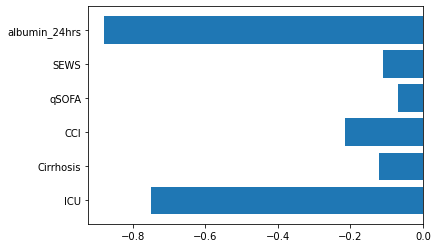

In [23]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

               Importance
qSOFA            0.933231
SEWS             0.894705
Cirrhosis        0.886225
CCI              0.806597
ICU              0.471873
albumin_24hrs    0.415056


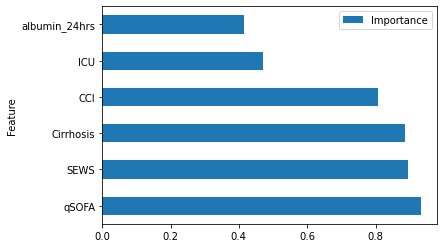

In [24]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [25]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [26]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[518 215 110]
 [284 326 223]
 [213 203 419]]


In [27]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.51      0.61      0.56       843
           1       0.44      0.39      0.41       833
           2       0.56      0.50      0.53       835

    accuracy                           0.50      2511
   macro avg       0.50      0.50      0.50      2511
weighted avg       0.50      0.50      0.50      2511



In [28]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[122  53  28]
 [ 75  78  59]
 [ 55  37 121]]


In [29]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.48      0.60      0.54       203
           1       0.46      0.37      0.41       212
           2       0.58      0.57      0.57       213

    accuracy                           0.51       628
   macro avg       0.51      0.51      0.51       628
weighted avg       0.51      0.51      0.51       628



## 1: Decision Tree 

In [30]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.00000
Feature: Cirrhosis Score: 0.00000
Feature: CCI Score: 0.52364
Feature: qSOFA Score: 0.04452
Feature: SEWS Score: 0.13336
Feature: albumin_24hrs Score: 0.29848


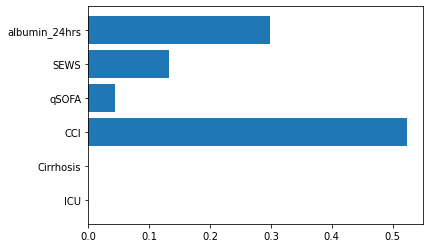

In [31]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [32]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [33]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[508 210 125]
 [222 331 280]
 [176 181 478]]


In [34]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.56      0.60      0.58       843
           1       0.46      0.40      0.43       833
           2       0.54      0.57      0.56       835

    accuracy                           0.52      2511
   macro avg       0.52      0.52      0.52      2511
weighted avg       0.52      0.52      0.52      2511



In [35]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[120  41  42]
 [ 68  73  71]
 [ 44  41 128]]


In [36]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.52      0.59      0.55       203
           1       0.47      0.34      0.40       212
           2       0.53      0.60      0.56       213

    accuracy                           0.51       628
   macro avg       0.51      0.51      0.50       628
weighted avg       0.51      0.51      0.50       628



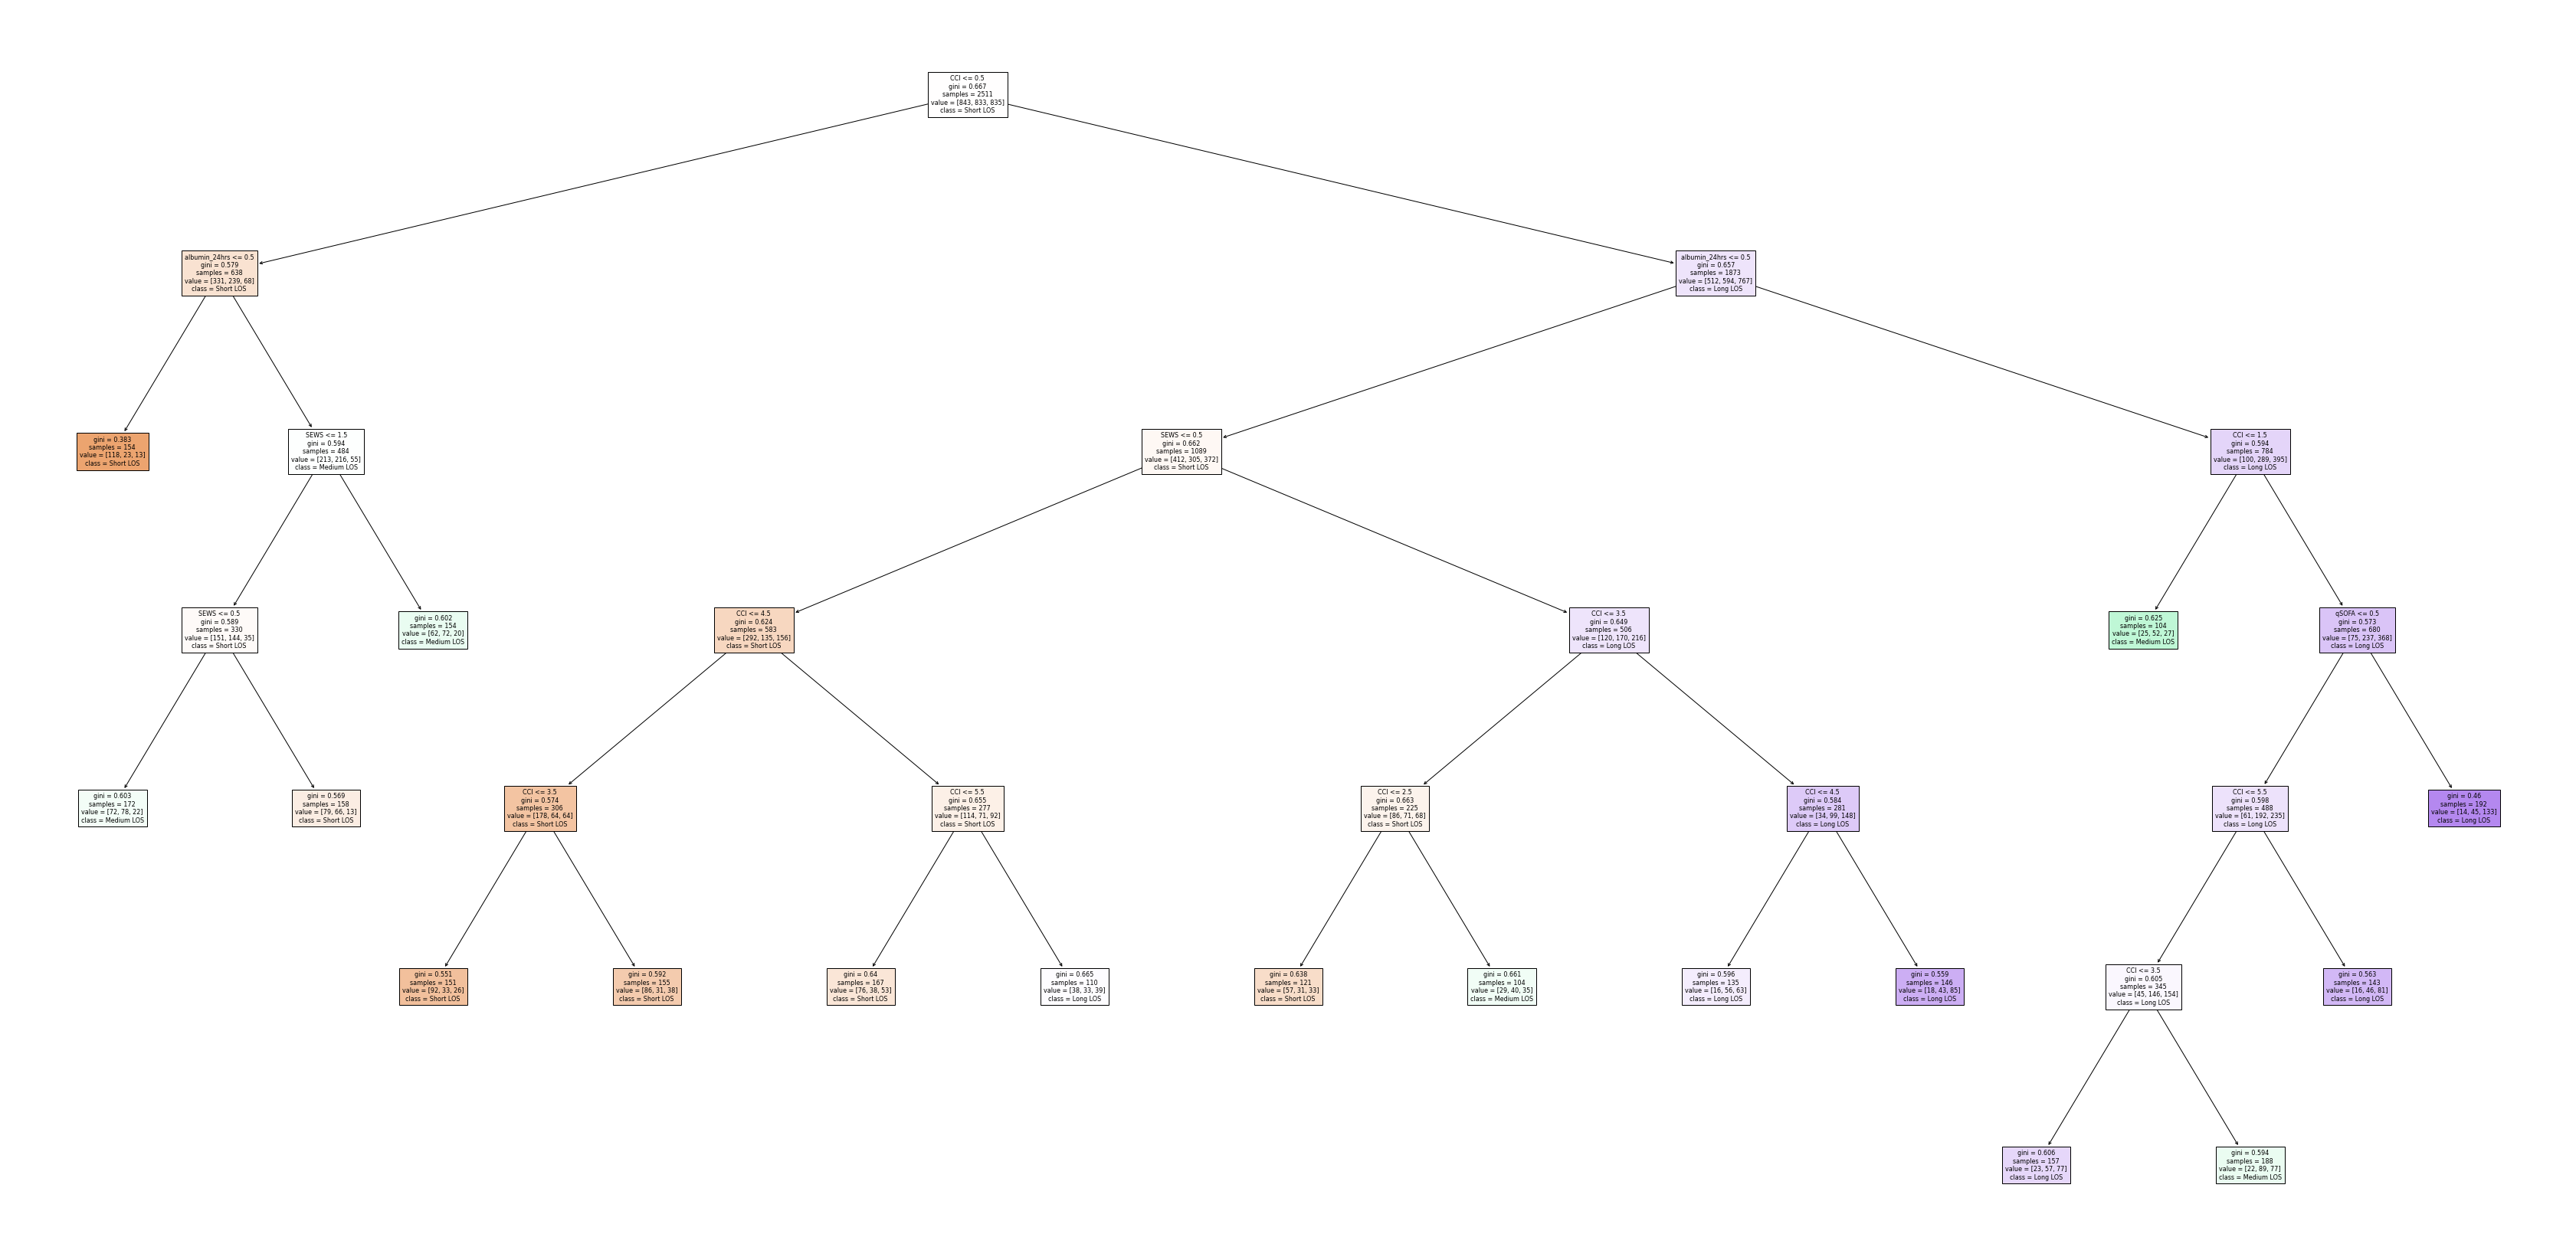

In [37]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [38]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('LOS_DT_D7_PSM_MATCHED.png')

## Random Forest

In [39]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [40]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [41]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[593 115 135]
 [322 183 328]
 [200  78 557]]


In [42]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.53      0.70      0.61       843
           1       0.49      0.22      0.30       833
           2       0.55      0.67      0.60       835

    accuracy                           0.53      2511
   macro avg       0.52      0.53      0.50      2511
weighted avg       0.52      0.53      0.50      2511



In [43]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[140  30  33]
 [ 86  39  87]
 [ 42  16 155]]


In [44]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.52      0.69      0.59       203
           1       0.46      0.18      0.26       212
           2       0.56      0.73      0.64       213

    accuracy                           0.53       628
   macro avg       0.51      0.53      0.50       628
weighted avg       0.51      0.53      0.50       628



Feature: ICU Score: 0.09231
Feature: Cirrhosis Score: 0.01328
Feature: CCI Score: 0.48310
Feature: qSOFA Score: 0.06906
Feature: SEWS Score: 0.09467
Feature: albumin_24hrs Score: 0.24757


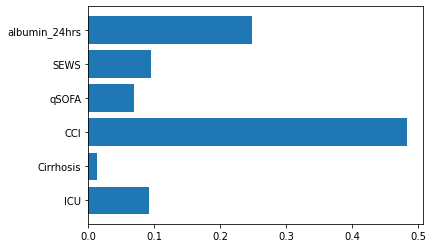

In [45]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()